<img src=../figures/Brown_logo.svg width=50%>

## Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture 20

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* This simple tutorial is still based on a script I created for this article: https://imechanica.org/node/23957
* It follows from some examples provided by the scikit-learn user guide, which seem to have originated from Mathieu Blondel, Jake Vanderplas, Vincent Dubourg, and Jan Hendrik Metzen.
* Creating a new StandardScaler for Gaussian Processes: https://stats.stackexchange.com/questions/364418/how-to-get-the-prediction-std-using-gaussian-process-in-scikit-learn
* The flower to explain the Iris dataset comes from this [source](https://www.ritchieng.com/machine-learning-iris-dataset/)

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the '3dasm' mamba (or conda) environment (see Lecture 1).
2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
    - Note: if you can't pull the repo due to conflicts (and you can't handle these conflicts), use this command (with **caution**!) and your repo becomes the same as the one online:
        ```
        git reset --hard origin/main
        ```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
jupyter notebook
```
5. Open notebook of this Lecture and choose the '3dasm' kernel.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Introduction to Supervised Learning for Classification

**Reading material**: This notebook + (Sections 1.2.1 + 2.4.2 + 10.1 + 10.2)

# Classification vs regression

So far in this course we have discussed Supervised Learning for **Regression**.

* Today we will start introducing Supervised Learning for **Classification**

Here's the good news:

* If you understand regression... Then, classification is *almost* the same thing...

**So, what is classification?**

* Classification problems occur when the target (output) is **discrete** (**categorical**), instead of being a continuous variable like we did in regression problems.

* A simple classification problem that is very common to consider when first learning about this topic is the [Iris dataset](http://archive.ics.uci.edu/ml/datasets/Iris) created by UCI researchers in 1936.

* I downloaded the .CSV file from [Kaggle](https://www.kaggle.com/) and it is included in the "data" folder of this GitHub repository.

Therefore, we can load that .CSV file into a Pandas DataFrame!

In [2]:
import pandas as pd

# Load the Iris dataset.
iris_data = pd.read_csv('../data/data_iris.csv')

print(iris_data)

      Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            5.1           3.5            1.4           0.2   
1      2            4.9           3.0            1.4           0.2   
2      3            4.7           3.2            1.3           0.2   
3      4            4.6           3.1            1.5           0.2   
4      5            5.0           3.6            1.4           0.2   
..   ...            ...           ...            ...           ...   
145  146            6.7           3.0            5.2           2.3   
146  147            6.3           2.5            5.0           1.9   
147  148            6.5           3.0            5.2           2.0   
148  149            6.2           3.4            5.4           2.3   
149  150            5.9           3.0            5.1           1.8   

            Species  
0       Iris-setosa  
1       Iris-setosa  
2       Iris-setosa  
3       Iris-setosa  
4       Iris-setosa  
..              ...  
145  

#### A short note

In fact, the Iris dataset is **so common**, that scikit-learn already has it saved and it can be loaded directly from the scikit-learn code, as shown below.

In [3]:
# In case you wanted to load the Iris dataset directly from scikit-learn.
from sklearn.datasets import load_iris

iris = load_iris() # load Iris dataset that already exists in Scikit-learn
# Convert it to a Pandas Dataframe
data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

# You can print(data1) and see that it is the same dataset (except the targets have different labels).
#print(data1)

But I think it is informative to understand the usual process in machine learning: someone gives us a dataset (or we download it from somewhere) and we usually load it with Pandas due to its versatility.

When you start a new problem, the first step is:

* Get to know the dataset.

What are the features? And the targets? What kind of data preprocessing should we do? What do we know *before* using machine learning tools to analyze the dataset?

<img src="../figures/iris_dataset_explanation.png" title="Flower to explain Iris dataset" width="25%" align="right">

Here's a nice image to understand the Iris dataset.

The dataset is quite simple! It has:

* 4 Features (inputs): sepal length, sepal width, petal length, petal width


* 1 Target (output): iris species (3 different species with 50 samples each)

So, the dataset has **150 samples** of **3 different species of iris flower** (50 samples per species) and each flower has **4 features (inputs)** that characterize it: the length and width of the petal and the sepal (see figure on the right).

**Our task**: Learn from part of the dataset how to classify a new iris flower into one of the 3 species!

Note: This example is straight out of Scikit-learn (but simplified)

In [4]:
# Let's only use the first two features (IGNORING THE OTHER 2).
X_2d_iris_data = iris_data.loc[:, ['SepalLengthCm','SepalWidthCm'] ].values # just use 2 inputs (features)
y_string_iris_data = iris_data.loc[:, 'Species'].values

print('y_string_iris_data = ',y_string_iris_data)

y_string_iris_data =  ['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versic

It's also very common to convert our target (output) data from strings to integers!

In this case we have three discrete target values ('Iris-setosa', 'Iris-versicolor' and 'Iris-virginica') so we can convert to 0, 1 and 2 (respectively):

In [5]:
# Pandas makes this very easy for us. Just one line!
y_iris_data = pd.Categorical(pd.factorize(y_string_iris_data)[0])

print('Targets: y_iris_data = ',y_iris_data)

Targets: y_iris_data =  [0, 0, 0, 0, 0, ..., 2, 2, 2, 2, 2]
Length: 150
Categories (3, int64): [0, 1, 2]


Let's see how to train a simple classifier (classification algorithm): Logistic Regression

**Notes**:

* We can do classification with many other algorithms!

* We will derive some simple ones in the next classes, e.g. linear models (Logistic Regression).

* But in your projects you will select other classification algorithms, explain them and derive them. Examples of common classification algorithms include **Logistic Regression** (Chapter 10), **Support Vector Machines** (Section 17.5), **Gaussian Processes** (Section 17.3 + Rasmussen book) , **Decision Trees** (Chapter 18) and **Artificial Neural Networks** (Chapters 13, 14 and 15), among many others.

Recall that in this course we made the decision of focusing on the fundamentals, explicitly covering fewer algorithms, but providing you the tools to understand any other algorithm that you want to use in your projects.

### Logistic regression classifier

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures # For Polynomial basis functions
from sklearn.pipeline import make_pipeline # to link different objects

# WARNING: I did not scale the data because this dataset is really simple, but NEVER do that!!!

C = 1e5  # Logistic Regression regularization parameter.
         # It is actually the inverse of regularization strength; must be a positive float.
         # Like in support vector machines, smaller values specify stronger regularization.

degree = 1 # Degree of polynomial is usually considered to be 1 (so usually, you don't even make a pipeline).
           #    Note: in this dataset, if you consider degree > 2, the 'lbfgs' optimizer with default
           #          parameters does not converge but you can use solver='newton-cholesky' in those cases.

LogReg_model = make_pipeline(PolynomialFeatures(degree), LogisticRegression(C=C, solver='lbfgs')) # model

LogReg_model.fit(X_2d_iris_data, y_iris_data) # HERE WE ARE USING ONLY 2 FEATURES TO FIT THE MODEL!
                                              # This is just to assess the predictive power of the SVC even though
                                              #  it is only using 2 features for training.
                                              # REMEMBER: WE USUALLY USE ALL FEATURES WHEN TRAINING A MODEL.

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('logisticregression', LogisticRegression(C=100000.0))])

In [7]:
from matplotlib import cm # to change colors of surface plots
n_classes = 3 # number of classes for this problem
plot_colors = 'ryb' # defining the 3 colors for each category
plot_step = 5e-3 # defining the meshgrid step size
target_names = iris_data.loc[:, 'Species'].unique() # retrieve the names of each category

# Create grid for plot:
x1_iris_data, x2_iris_data = X_2d_iris_data[:, 0], X_2d_iris_data[:, 1]

x1_iris_data_min, x1_iris_data_max = x1_iris_data.min() - 1, x1_iris_data.max() + 1 # define min & max of feature 0
x2_iris_data_min, x2_iris_data_max = x2_iris_data.min() - 1, x2_iris_data.max() + 1 # define min & max of feature 1
X1_iris_data_grid, X2_iris_data_grid = np.meshgrid(np.arange(x1_iris_data_min, x1_iris_data_max, plot_step),
                                                   np.arange(x2_iris_data_min, x2_iris_data_max, plot_step))
# Predict for grid points:
y_iris_data_LogReg_pred = LogReg_model.predict(np.c_[X1_iris_data_grid.ravel(), X2_iris_data_grid.ravel()])
Y_iris_data_LogReg_grid = y_iris_data_LogReg_pred.reshape(X1_iris_data_grid.shape)

fig1, ax1 = plt.subplots(tight_layout=True)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax1.contourf(X1_iris_data_grid, X2_iris_data_grid, Y_iris_data_LogReg_grid, cmap=cm.RdYlBu, alpha=0.8)

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_iris_data == i)
    ax1.scatter(X_2d_iris_data[idx, 0], X_2d_iris_data[idx, 1], c=color,
                label=target_names[i], edgecolor='black', s=15)

ax1.set_xlim(X1_iris_data_grid.min(), X1_iris_data_grid.max())
ax1.set_ylim(X2_iris_data_grid.min(), X2_iris_data_grid.max())
ax1.set_xlabel('Sepal length', fontsize=20)
ax1.set_ylabel('Sepal width', fontsize=20)
#ax1.set_xticks(())
#ax1.set_yticks(())
ax1.legend(loc='lower right', borderpad=0, handletextpad=0, fontsize=15)
ax1.set_title('Logistic regression with RBF kernel', fontsize=20)
plt.close(fig1)

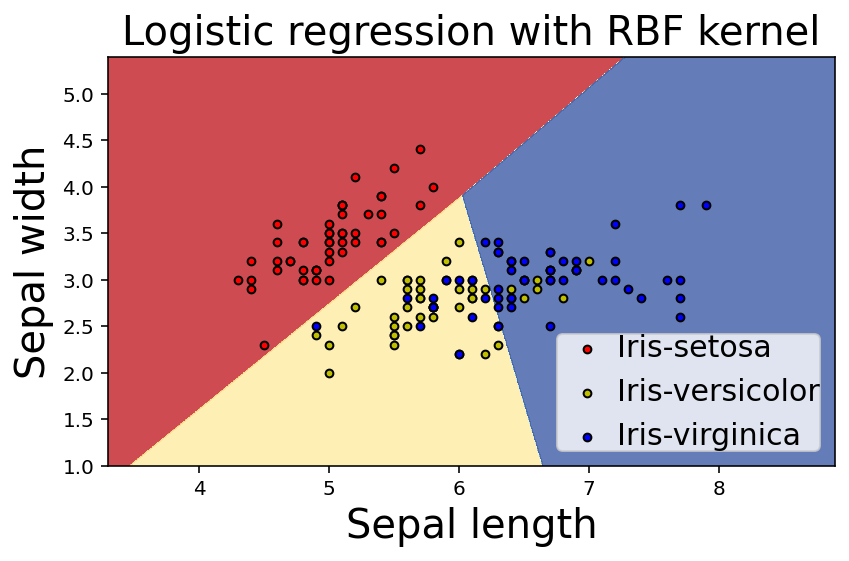

In [8]:
fig1

### In-class exercise

Go back and train the Logistic Regression model using:

1. A polynomial basis of degree 2

2. A polynomial basis of degree 4 (illustrate why there are different optimizer choices!)

### Support Vector Machine classifier

As usual, using other classification algorithms to do the same task is straightforward!

For example, here's the same prediction using a **Support Vector Machine (SVM)**. This is a very common classifier for small datasets (it's like a simplified and deterministic version of a Gaussian process classifier).

In [9]:
from sklearn import svm
# we create an instance of SVM and fit out data. We did not scale our data (this dataset is quite simple)

SVM_model = svm.SVC(kernel='rbf', gamma=0.7, C=1.0) # - kernel like in GPs
                                                    # - gamma is the kernel hyperparameter (here: length-scale)
                                                    # - C is a l2 regularization parameter (strength of 
                                                    #   regularization is inversely proportional to C)

SVM_model.fit(X_2d_iris_data, y_iris_data) # HERE WE ARE USING ONLY 2 FEATURES TO FIT THE MODEL!
                                           # This is just to assess the predictive power of the SVC even though
                                           #  it is only using 2 features for training.
                                           # REMEMBER: WE USUALLY USE ALL FEATURES WHEN TRAINING A MODEL.

SVC(gamma=0.7)

In [10]:
# Make same prediction using SVM:
y_iris_data_SVM_pred = SVM_model.predict(np.c_[X1_iris_data_grid.ravel(), X2_iris_data_grid.ravel()])
Y_iris_data_SVM_grid = y_iris_data_SVM_pred.reshape(X1_iris_data_grid.shape)


fig2, ax2 = plt.subplots(tight_layout=True)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax2.contourf(X1_iris_data_grid, X2_iris_data_grid, Y_iris_data_SVM_grid, cmap=cm.RdYlBu, alpha=0.8)

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_iris_data == i)
    ax2.scatter(X_2d_iris_data[idx, 0], X_2d_iris_data[idx, 1], c=color,
                label=target_names[i], edgecolor='black', s=15)

ax2.set_xlim(X1_iris_data_grid.min(), X1_iris_data_grid.max())
ax2.set_ylim(X2_iris_data_grid.min(), X2_iris_data_grid.max())
ax2.set_xlabel('Sepal length', fontsize=20)
ax2.set_ylabel('Sepal width', fontsize=20)
#ax2.set_xticks(())
#ax2.set_yticks(())
ax2.legend(loc='lower right', borderpad=0, handletextpad=0, fontsize=15)
ax2.set_title('Support Vector Machine Classifier (SVC) with RBF kernel', fontsize=20)

plt.close(fig2)

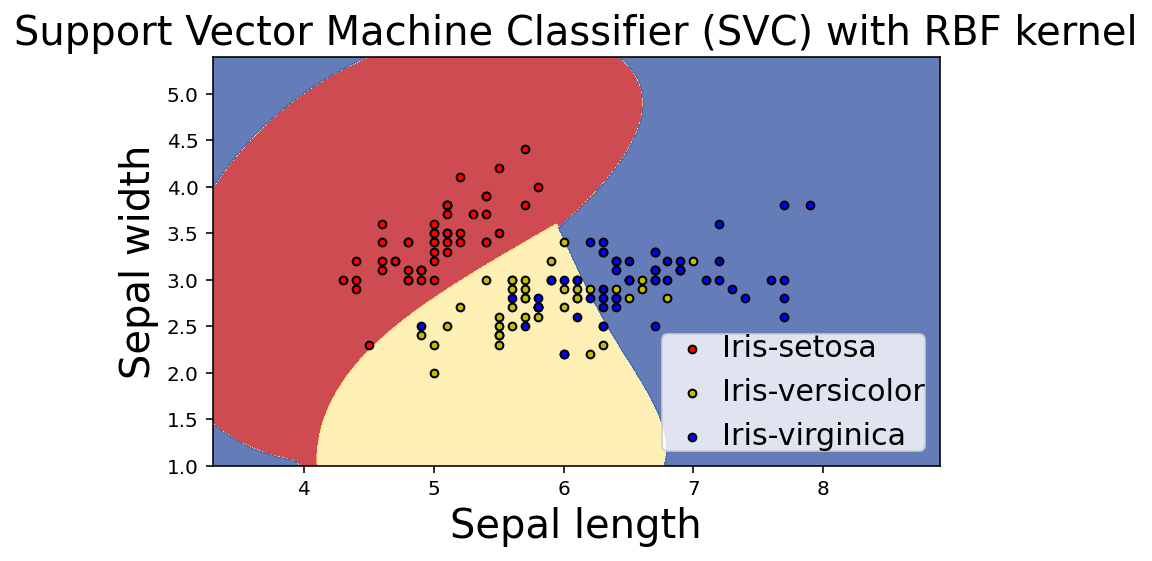

In [11]:
fig2 # classification plot using only 2 features ('SepalLengthCm' and 'SepalWidthCm')

### Decision tree classifier example

Let's use another classifier: **Decision Trees**.

But this time, **we will still train only using 2 features (inputs)** but we will do the **training for all possible pairs of features (6 pairs)**.

* This is just for you to have an idea about the quality of the prediction when you use different information.

* Note: Usually that is **not** what you do in practice! We typically want to use all the input features (in this case 4) in an attempt to make better predictions, but then you need to be careful with how to visualize the predictions.

In [12]:
# Load all the features (the targets were loaded in a previous cell)
X_iris_data = iris_data.iloc[:, 1:5 ].values # now using all 4 features (inputs)
feature_names = iris_data.columns.values[1:5] # not including the "ID" column

print(feature_names)
print(target_names)

['SepalLengthCm' 'SepalWidthCm' 'PetalLengthCm' 'PetalWidthCm']
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [13]:
from sklearn.tree import DecisionTreeClassifier

fig3, ax3 = plt.subplots(tight_layout=True) # open figure
ax3.remove() # create a clean figure without axes (because we will add subplots in a loop)
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    #
    X_iris_data_temp = X_iris_data[:, pair]
    
    # Train Decision Tree
    DT_model = DecisionTreeClassifier().fit(X_iris_data_temp, y_iris_data) # Fit the model only to these 2 features
                                                  # NOTE: here we are doing this so that we can assess
                                                  #the predictive power of the decision tree even though
                                                  #it is using only 2 features (instead of all 4!)
                                                  # REMEMBER: USUALLY WE USE ALL FEATURES WHEN TRAINING A MODEL
    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x1_iris_data_min, x1_iris_data_max = X_iris_data_temp[:, 0].min() - 1, X_iris_data_temp[:, 0].max() + 1
    x2_iris_data_min, x2_iris_data_max = X_iris_data_temp[:, 1].min() - 1, X_iris_data_temp[:, 1].max() + 1
    X1_iris_data_grid, X2_iris_data_grid = np.meshgrid(np.arange(x1_iris_data_min, x1_iris_data_max, plot_step),
                                                       np.arange(x2_iris_data_min, x2_iris_data_max, plot_step))

    Y_iris_data = DT_model.predict(np.c_[X1_iris_data_grid.ravel(), X2_iris_data_grid.ravel()])
    Y_iris_data_grid = Y_iris_data.reshape(X1_iris_data_grid.shape)
    cs = plt.contourf(X1_iris_data_grid, X2_iris_data_grid, Y_iris_data_grid, cmap=cm.RdYlBu)

    plt.xlabel(feature_names[pair[0]], fontsize=20)
    plt.ylabel(feature_names[pair[1]], fontsize=20)

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_iris_data == i)
        plt.scatter(X_iris_data_temp[idx, 0], X_iris_data_temp[idx, 1],
                    c=color, label=target_names[i], edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features", fontsize=20)
plt.legend(loc='lower right', borderpad=0, handletextpad=0, fontsize=15)
fig3.set_size_inches(15, 6)
plt.close(fig3)

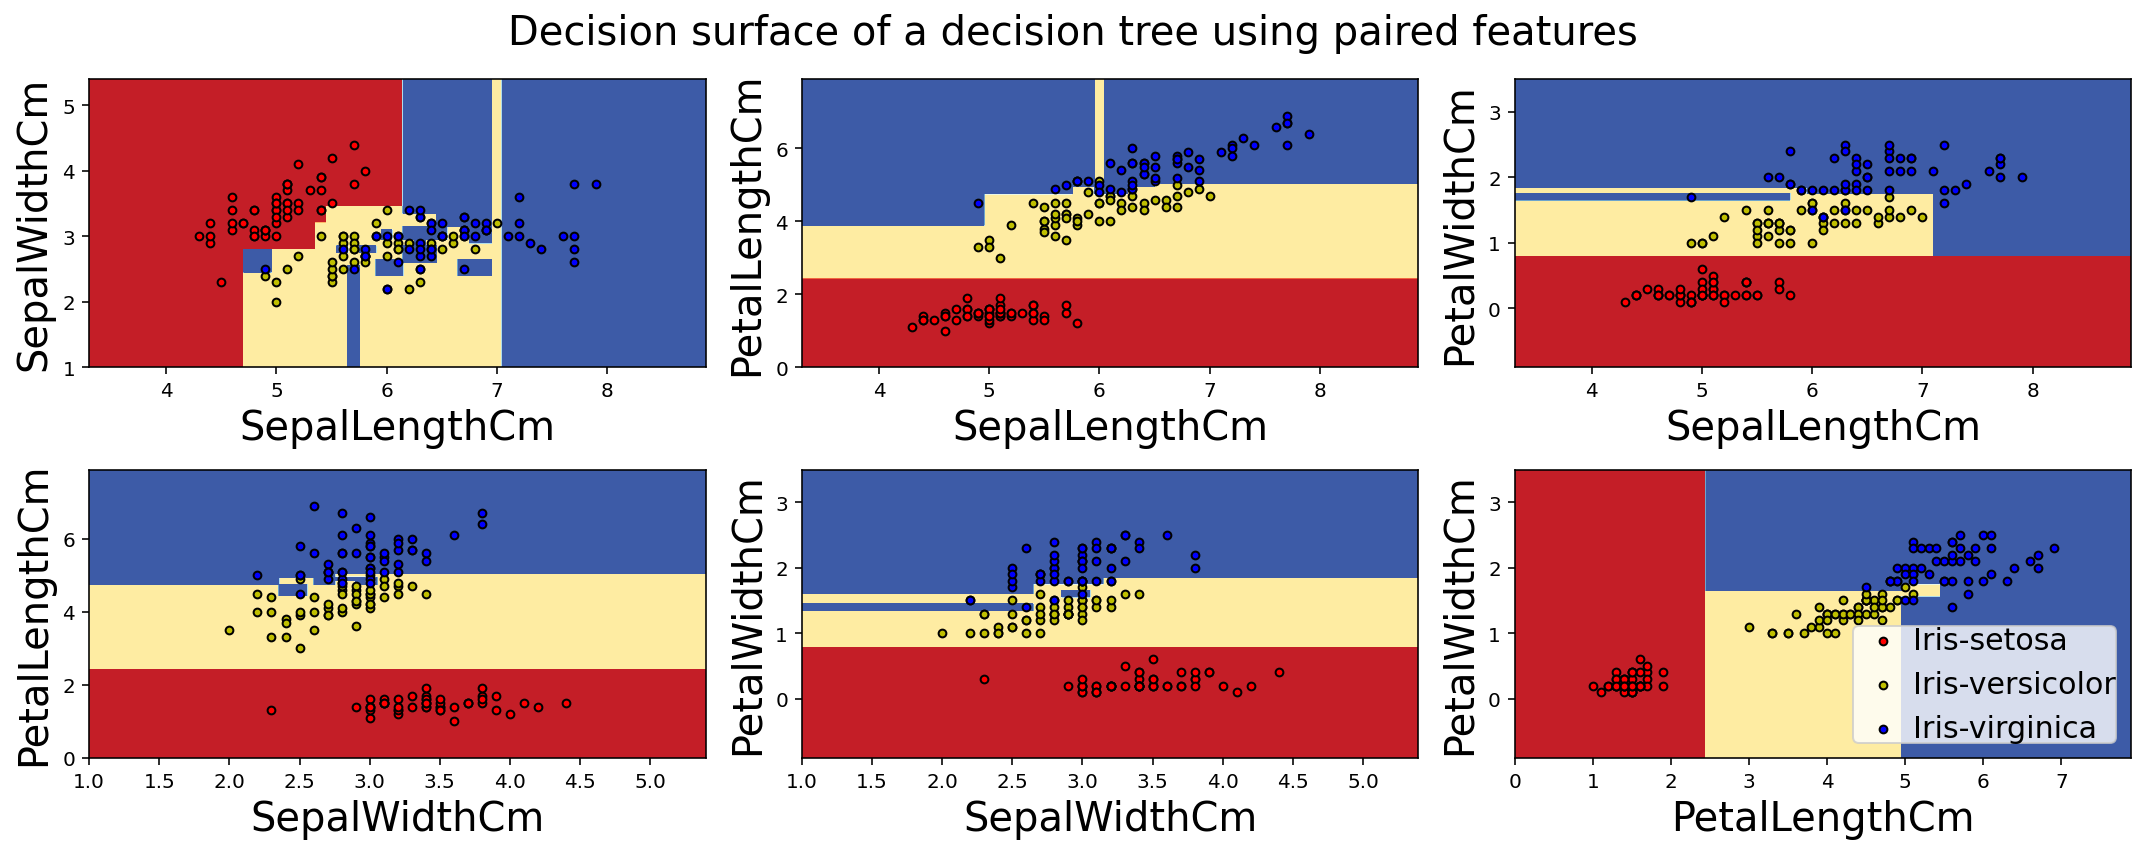

In [14]:
fig3 # classification plot with Decision Trees train with each possible pair of 2 features

#### Notes about visualization in multidimensional spaces

As just mentioned, usually we **do not want** to train just using 2 pairs of features (like we did in the figure above)! Instead we typically use all the information available to create better predictions!

* So, we train considering all features (e.g. using all 4 features of the Iris dataset)
* After training using all features, we can plot the model predictions on slices of the space. These slices can be created by allowing to vary 2 features and making all other features constant (you can do this because you have trained the model, and so you can make predictions for any input values you desire).
    * There are more advanced ways to visualize predictions in multidimensional spaces. For example, we can use *dimensionality reduction* techniques to reduce the number of features to fewer representative features that create more informative plots. Another example is the use of *sensitivity analysis* to select the more important features (without transforming them).

### You will explore more about Classification in your Final projects

We will also derive some simple models in the next couple of classes.

Have fun!